In [1]:
import numpy as np
import pandas as pd

from scipy.stats import zscore

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import metrics

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

from catboost import CatBoostClassifier

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform


In [2]:
def classification_metrics(estimator, X_test, y_test, name, threshold=None):
    y_proba = estimator.predict_proba(X_test)[:, 1]

    if threshold is None:
        y_pred = estimator.predict(X_test)
    else:
        y_pred = (y_proba >= threshold).astype(int)

    accuracy = round(metrics.accuracy_score(y_test, y_pred), 4)
    recall = round(metrics.recall_score(y_test, y_pred), 4)
    precision = round(metrics.precision_score(y_test, y_pred), 4)
    f1 = round(metrics.f1_score(y_test, y_pred), 4)
    log_loss = round(metrics.log_loss(y_test, y_proba), 4)   # logloss считается по вероятностям
    roc_auc = round(metrics.roc_auc_score(y_test, y_proba), 4)

    return [name, roc_auc, accuracy, precision, recall, f1, log_loss]

results_df = pd.DataFrame(columns=['estimator', 'roc-auc', 'accuracy', 'precision', 'recall', 'f1-score', 'log-loss'])

In [3]:
df = pd.read_csv('bank.csv')
df['deposit'] = (df['deposit'] == 'yes').astype(int)
df.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome  deposit  
0    5   may      1042         1     -1         0  unknown        1  
1    5   may      1467         1     -1         0  unknown        1  
2    5   may      1389         1     -1         0  unknown        1  
3    5   may       579         1     -1         0  unknown        1  
4    5   may       673         2     -1         0  unknown        1

### EDA

In [4]:
categorical_cols = [
    'job', 'marital', 'education', 'default', 'housing', 'loan',
    'contact', 'month', 'campaign', 'previous', 'poutcome', 'day'
]

numeric_cols = [column for column in df.columns 
                if column not in categorical_cols
                and column != 'deposit']


CATEGORICAL COLUMNS


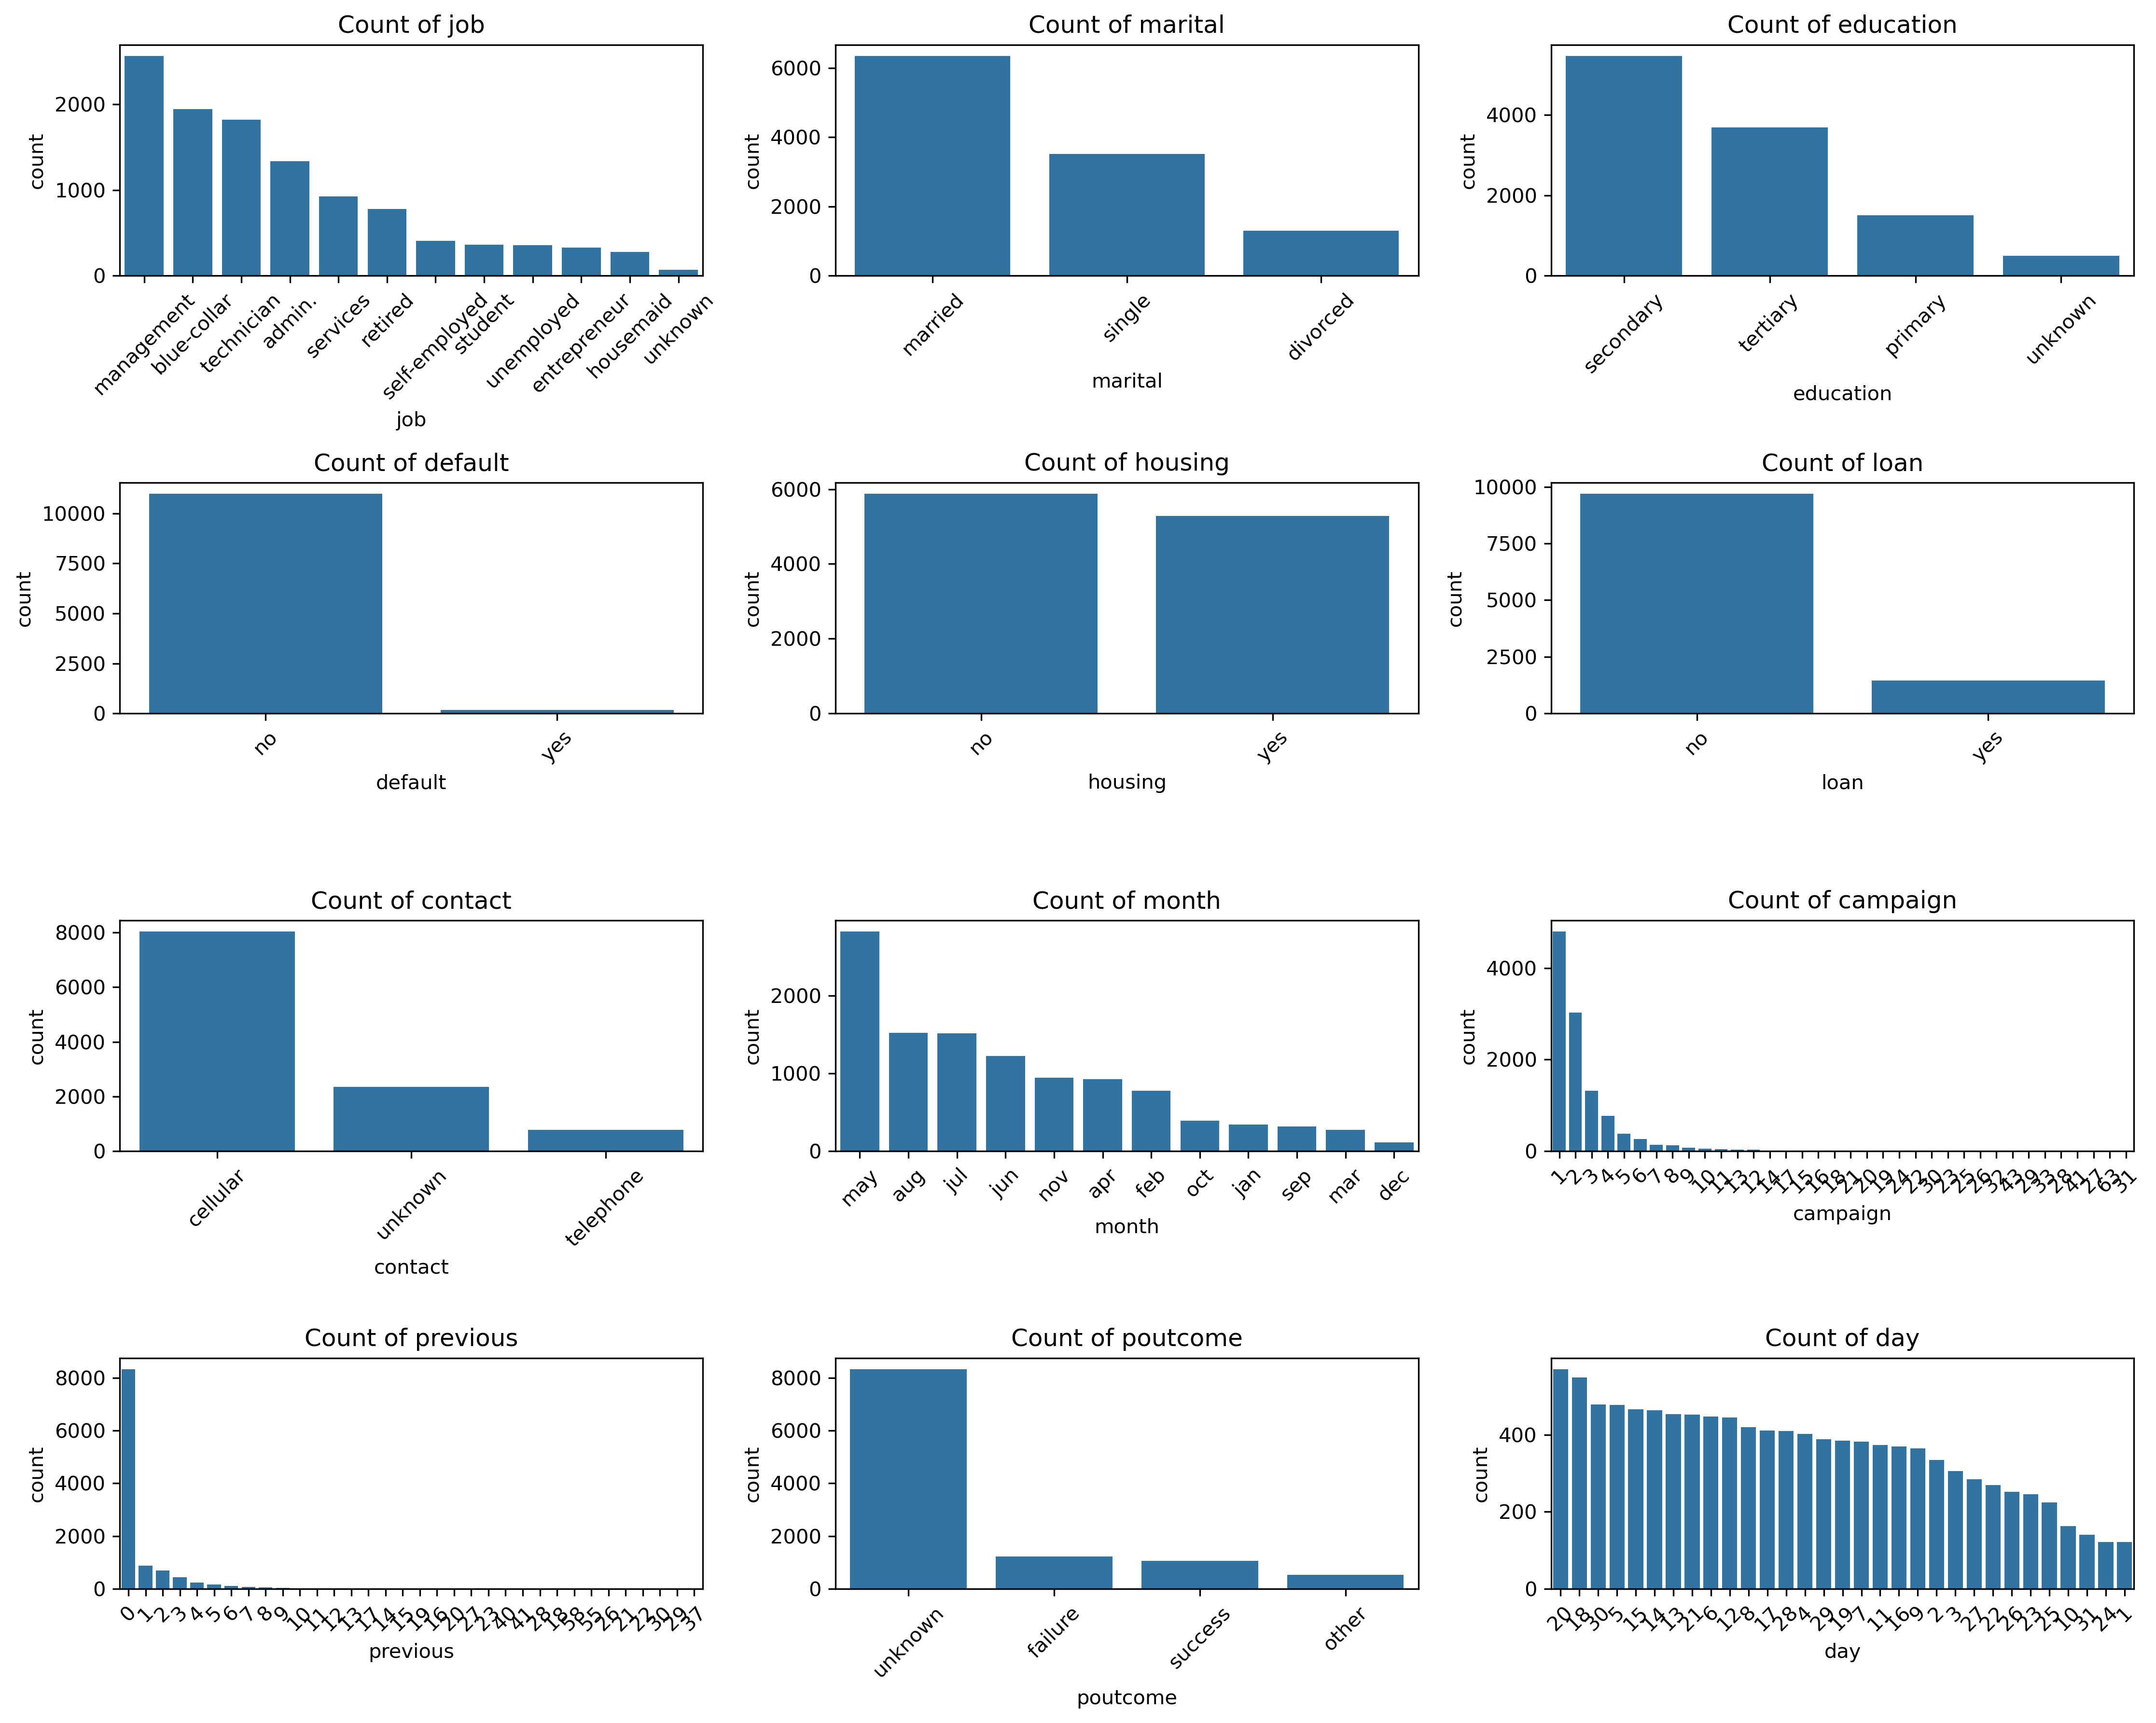

In [5]:
print('CATEGORICAL COLUMNS')
plt.figure(figsize=(15,12), dpi=300)

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(4, 3, i)
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Count of {col}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

NUMERIC COLUMNS


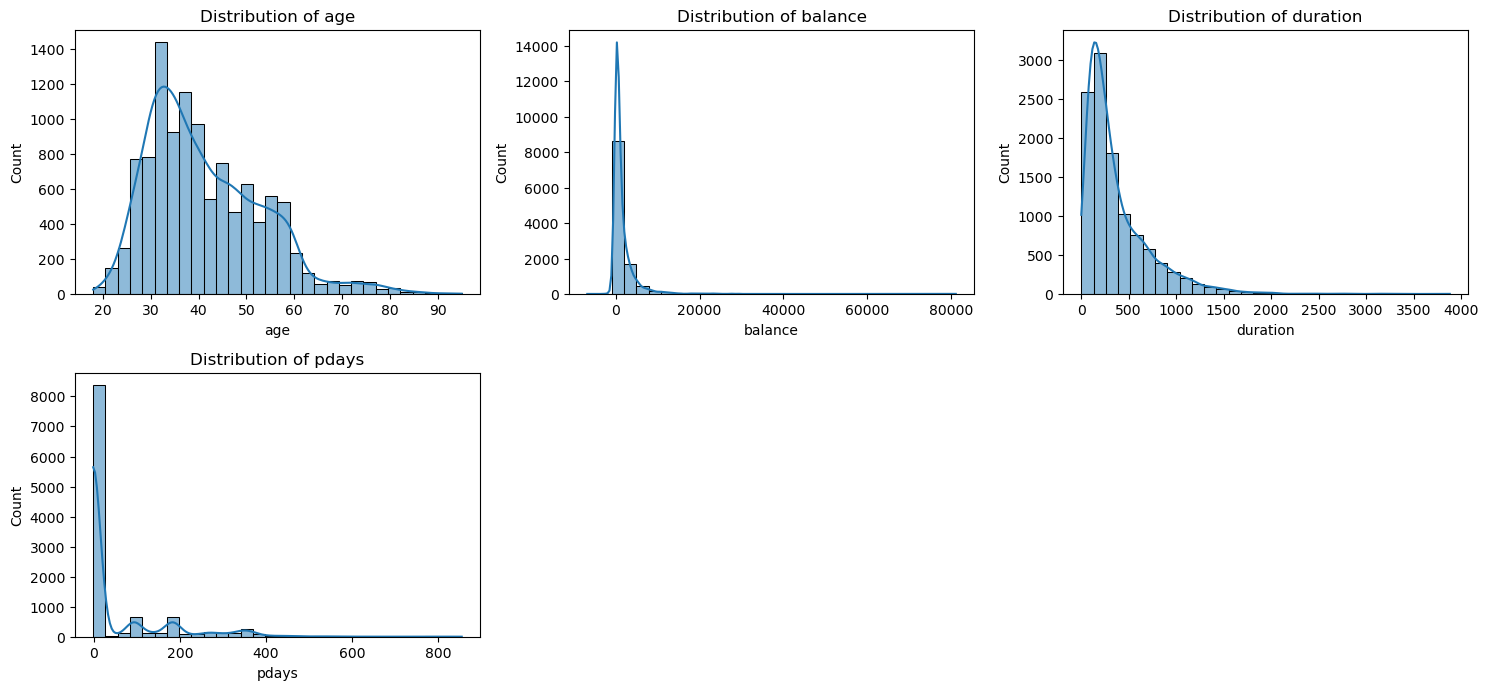

In [6]:
print('NUMERIC COLUMNS')
plt.figure(figsize=(15,10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

CORRELATION MATRIX (WITH LABEL ENCODING)


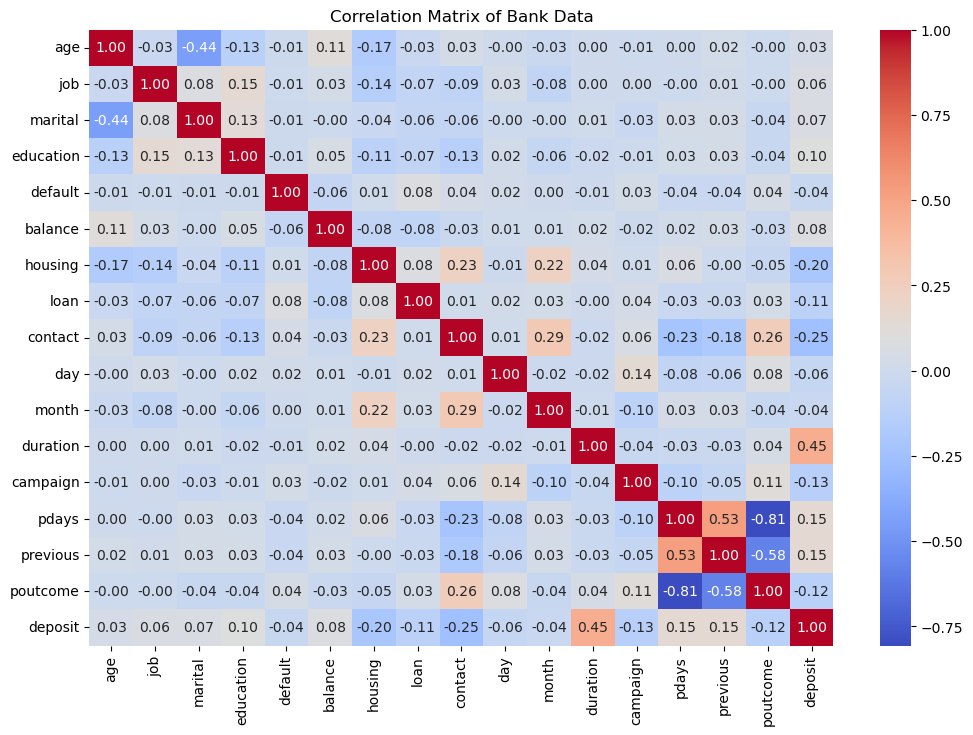

In [7]:
print('CORRELATION MATRIX (WITH LABEL ENCODING)')

non_binary_cols = [col for col in categorical_cols]
encoders = {}

le = LabelEncoder()
for col in non_binary_cols:
    df[col] = le.fit_transform(df[col])
    encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))

corr_matrix = df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Bank Data")
plt.show()

### Feature Engineering

In [8]:
# irrelevant_cols = ['duration'] # it’s only known after the marketing call.
# df = df.drop(columns=irrelevant_cols)

In [9]:
df['contacted_before'] = (df['pdays'] != -1).astype(int)
df.drop(['pdays', 'previous'], axis=1, inplace=True)
print(df['contacted_before'].value_counts())

contacted_before
0    8324
1    2838
Name: count, dtype: int64


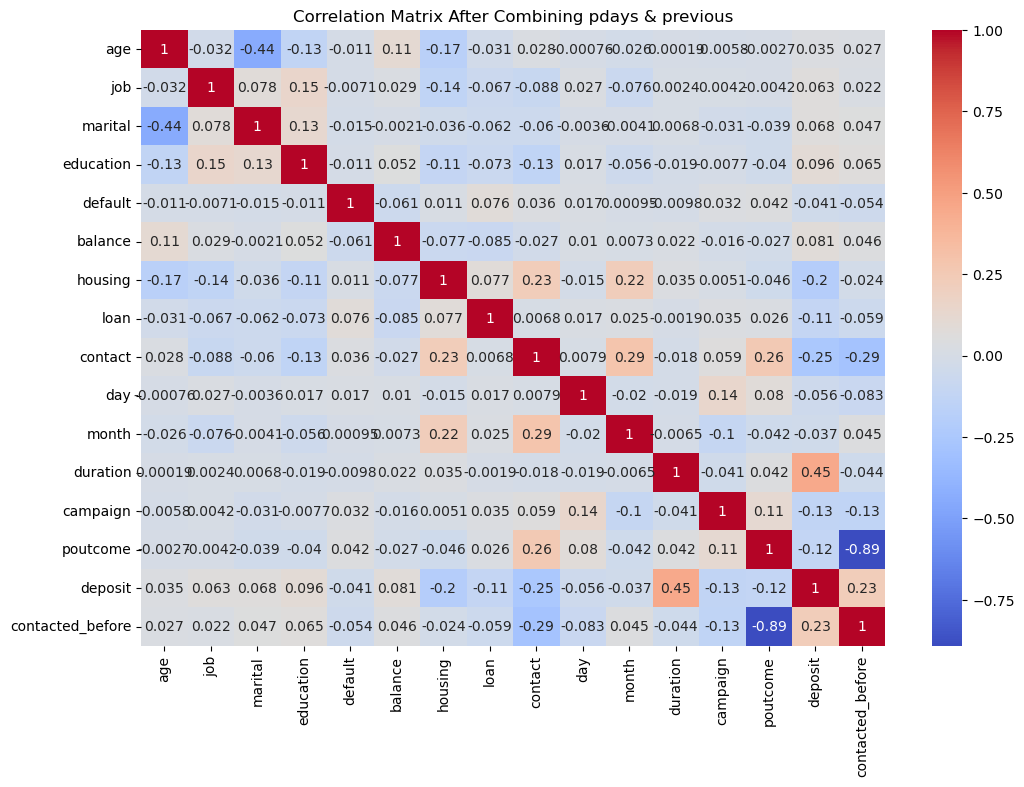

In [10]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix After Combining pdays & previous")
plt.show()

balance & duration have outliers

In [11]:
# remove outliers
df['balance_zscore'] = zscore(df['balance'])
df['duration_zscore'] = zscore(df['duration'])

threshold = 2

df = df[
    (abs(df['balance_zscore']) <= threshold) &
    (abs(df['duration_zscore']) <= threshold)
].drop(['balance_zscore', 'duration_zscore'], axis=1)

### Finally choose categorical and numerical columns

In [12]:
categorical_cols = [
    'job', 'marital', 'education', 'default', 'housing', 'loan',
    'contact', 'month', 'campaign', 'poutcome'
]

numeric_cols = [column for column in df.columns 
                if column not in categorical_cols
                and column != 'deposit']


In [13]:
for col in categorical_cols:
    df[col] = df[col].astype("category") # for future catboost

### Random Forest

In [14]:
X = df.drop(columns=['deposit'])
y = df['deposit']

In [15]:
enc = OneHotEncoder()

encoded_df = pd.DataFrame(
    enc.fit_transform(X[categorical_cols]).toarray(), 
    columns=enc.get_feature_names_out(categorical_cols)
)
encoded_df.index = X.index

X = pd.concat([X, encoded_df], axis=1)
X = X.drop(columns=categorical_cols)

In [16]:
X_forest_train, X_forest_test, y_forest_train, y_forest_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
forest = RandomForestClassifier(n_estimators=50, random_state=42, criterion='log_loss')

param_grid = {
    'max_depth': [10,15,20],
    'min_samples_split': [5,10,20,30,40,50],
    'min_samples_leaf': [5,10,15,20], 
    'max_features': ['sqrt', 'log2', None]
}

In [18]:
grid_search = GridSearchCV(forest, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_forest_train, y_forest_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='log_loss',
                                              n_estimators=50,
                                              random_state=42),
             param_grid={'max_depth': [10, 15, 20],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'min_samples_split': [5, 10, 20, 30, 40, 50]},
             scoring='roc_auc')

In [19]:
best_forest = grid_search.best_estimator_
print("Best params for random forest on deep trees:", grid_search.best_params_)

Best params for random forest on deep trees: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 30}


In [20]:
results_df.loc[len(results_df)] = classification_metrics(best_forest, X_forest_test, y_forest_test, 'Random Forest')
results_df

estimator  roc-auc  accuracy  precision  recall  f1-score  log-loss
0  Random Forest   0.9167    0.8476     0.8146  0.8585     0.836    0.3576

### Multi Layer Perceptron Classifier

In [21]:
X = df.drop(columns=['deposit'])
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [22]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ]
)

In [23]:
clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("mlp", MLPClassifier(max_iter=500, random_state=42))
])

In [24]:
param_grid = {
    "mlp__hidden_layer_sizes": [(64, 32), (128, 64), (128, 64, 32)],
    "mlp__activation": ["relu"],
    "mlp__solver": ["adam"],
    "mlp__alpha": [0.0001, 0.001, 0.01],
    "mlp__learning_rate_init": [0.001, 0.01],
}

grid = GridSearchCV(
    clf,
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(64, 32), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=   0.9s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(64, 32), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=   0.9s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(64, 32), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=   0.9s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=   1.5s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=   1.7s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64), mlp__learning_rate_init=0.01, mlp__solver=adam; total time=   1.9s
[CV] END mlp__activation=relu,

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'campaign',
                                                                          'poutcome']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'balance',
                                                                          'day',
                                                                          'duration',
                                                                          'contacted_before'])])),
                                       ('mlp',
                                        MLPClassifier(max_iter=500,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'mlp__activation': ['relu'],
                         'mlp__alpha': [0.0001, 0.001, 0.01],
                         'mlp__hidden_layer_sizes': [(64, 32), (128, 64),
                                                     (128, 64, 32)],
                         'mlp__learning_rate_init': [0.001, 0.01],
                         'mlp__solver': ['adam']},
             scoring='roc_auc', verbose=2)

In [25]:
best_mlp = grid.best_estimator_

In [26]:
results_df.loc[len(results_df)] = classification_metrics(best_mlp, X_test, y_test, 'MLP Classifier')
results_df

estimator  roc-auc  accuracy  precision  recall  f1-score  log-loss
0   Random Forest   0.9167    0.8476     0.8146  0.8585    0.8360    0.3576
1  MLP Classifier   0.8821    0.8080     0.7814  0.7989    0.7901    1.4000

### Logistic Regression

In [27]:
X = df.drop(columns=['deposit'])
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ]
)

In [29]:
logreg = LogisticRegression(
    max_iter=500,
    solver="lbfgs",
    random_state=42
)

In [30]:
clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("logreg", logreg)
])

In [31]:
param_grid = {
    "logreg__C": [0.01, 0.1, 1, 5, 10],
    "logreg__penalty": ["l2"],
}

grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [32]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'campaign',
                                                                          'poutcome']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'balance',
                                                                          'day',
                                                                          'duration',
                                                                          'contacted_before'])])),
                                       ('logreg',
                                        LogisticRegression(max_iter=500,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.01, 0.1, 1, 5, 10],
                         'logreg__penalty': ['l2']},
             scoring='roc_auc', verbose=1)

In [33]:
print("Best params:", grid.best_params_)
print("Best ROC-AUC (CV):", round(grid.best_score_, 4))

Best params: {'logreg__C': 1, 'logreg__penalty': 'l2'}
Best ROC-AUC (CV): 0.9044


In [34]:
best_logreg = grid.best_estimator_

In [35]:
results_df.loc[len(results_df)] = classification_metrics(best_logreg, X_test, y_test, 'Logistic Regression')
results_df

estimator  roc-auc  accuracy  precision  recall  f1-score  \
0        Random Forest   0.9167    0.8476     0.8146  0.8585    0.8360   
1       MLP Classifier   0.8821    0.8080     0.7814  0.7989    0.7901   
2  Logistic Regression   0.8999    0.8177     0.8108  0.7787    0.7944   

   log-loss  
0    0.3576  
1    1.4000  
2    0.4071

### Catboost

In [36]:
cat_features = [df.columns.get_loc(col) for col in categorical_cols]

X_cat_train, X_cat_test, y_train, y_test = train_test_split(
    df.drop(columns=['deposit']),
    df['deposit'], 
    test_size=0.3,
    random_state=42
)

In [37]:
cat_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=False,
    cat_features=cat_features
)

In [38]:
param_distributions = {
    'depth': randint(4, 11),
    'learning_rate': uniform(0.01, 0.1),
    'l2_leaf_reg': randint(1, 15),
    'iterations': randint(300, 1200)
}

search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_distributions,
    n_iter=30,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42
)

In [39]:
search.fit(X_cat_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x32b944ef0>,
                   n_iter=30,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16dcdc6e0>,
                                        'iterations': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x32b946d20>,
                                        'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16d995130>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x32b3c83b0>},
                   random_state=42, scoring='roc_auc', verbose=1)

In [40]:
print("Best params:", search.best_params_)
print("Best CV ROC-AUC:", search.best_score_)

Best params: {'depth': 6, 'iterations': 946, 'l2_leaf_reg': 5, 'learning_rate': 0.05504992519695431}
Best CV ROC-AUC: 0.9304063026725317


In [41]:
best_cat = search.best_estimator_

In [42]:
results_df.loc[len(results_df)] = classification_metrics(best_cat, X_cat_test, y_test, 'CatBoost', threshold=None)
results_df

estimator  roc-auc  accuracy  precision  recall  f1-score  \
0        Random Forest   0.9167    0.8476     0.8146  0.8585    0.8360   
1       MLP Classifier   0.8821    0.8080     0.7814  0.7989    0.7901   
2  Logistic Regression   0.8999    0.8177     0.8108  0.7787    0.7944   
3             CatBoost   0.9289    0.8522     0.8194  0.8635    0.8409   

   log-loss  
0    0.3576  
1    1.4000  
2    0.4071  
3    0.3316

### LightGBM

In [43]:
lgbm_model = lgb.LGBMClassifier(
    objective='binary',
    random_state=42
)

In [44]:
param_distributions = {
    "num_leaves": randint(16, 256),
    "max_depth": randint(-1, 12),
    "learning_rate": uniform(0.01, 0.2),
    "n_estimators": randint(200, 1500),
    "min_child_samples": randint(10, 50),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),
}

search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="roc_auc",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

search.fit(
    X_cat_train,
    y_train,
    categorical_feature=categorical_cols
)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 2133, number of negative: 2654
[LightGBM] [Info] Number of positive: 2133, number of negative: 2654
[LightGBM] [Info] Number of positive: 2133, number of negative: 2653
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 4787, number of used features: 15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(objective='binary',
                                            random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x32b8eab40>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x32b8e8d40>,
                                        'max_depth': <scipy.stats._distn_infra...
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x32b8e9e80>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x32b8ea060>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x32b8f0350>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x32b8ea4e0>},
                   random_state=42, scoring='roc_auc', verbose=2)

In [45]:
print("Best params:", search.best_params_)
print("Best CV ROC-AUC:", search.best_score_)

Best params: {'colsample_bytree': 0.8166031869068445, 'learning_rate': 0.06426980635477918, 'max_depth': 3, 'min_child_samples': 33, 'n_estimators': 416, 'num_leaves': 203, 'subsample': 0.8628088249474745}
Best CV ROC-AUC: 0.9261225034734175


In [46]:
best_lgbm = search.best_estimator_

In [47]:
results_df.loc[len(results_df)] = classification_metrics(best_lgbm, X_cat_test, y_test, 'LightGBM', threshold=None)
results_df

estimator  roc-auc  accuracy  precision  recall  f1-score  \
0        Random Forest   0.9167    0.8476     0.8146  0.8585    0.8360   
1       MLP Classifier   0.8821    0.8080     0.7814  0.7989    0.7901   
2  Logistic Regression   0.8999    0.8177     0.8108  0.7787    0.7944   
3             CatBoost   0.9289    0.8522     0.8194  0.8635    0.8409   
4             LightGBM   0.9247    0.8502     0.8226  0.8527    0.8374   

   log-loss  
0    0.3576  
1    1.4000  
2    0.4071  
3    0.3316  
4    0.3412

## Results

In [48]:
results_df.sort_values(by='roc-auc', ascending=False).set_index('estimator')

roc-auc  accuracy  precision  recall  f1-score  log-loss
estimator                                                                    
CatBoost              0.9289    0.8522     0.8194  0.8635    0.8409    0.3316
LightGBM              0.9247    0.8502     0.8226  0.8527    0.8374    0.3412
Random Forest         0.9167    0.8476     0.8146  0.8585    0.8360    0.3576
Logistic Regression   0.8999    0.8177     0.8108  0.7787    0.7944    0.4071
MLP Classifier        0.8821    0.8080     0.7814  0.7989    0.7901    1.4000

In [49]:
def roc(estimator, X_test, y_test):
    pred_proba = estimator.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba[:, 1])

    return fpr, tpr, thresholds, metrics.roc_auc_score(y_test, pred_proba[:, 1])

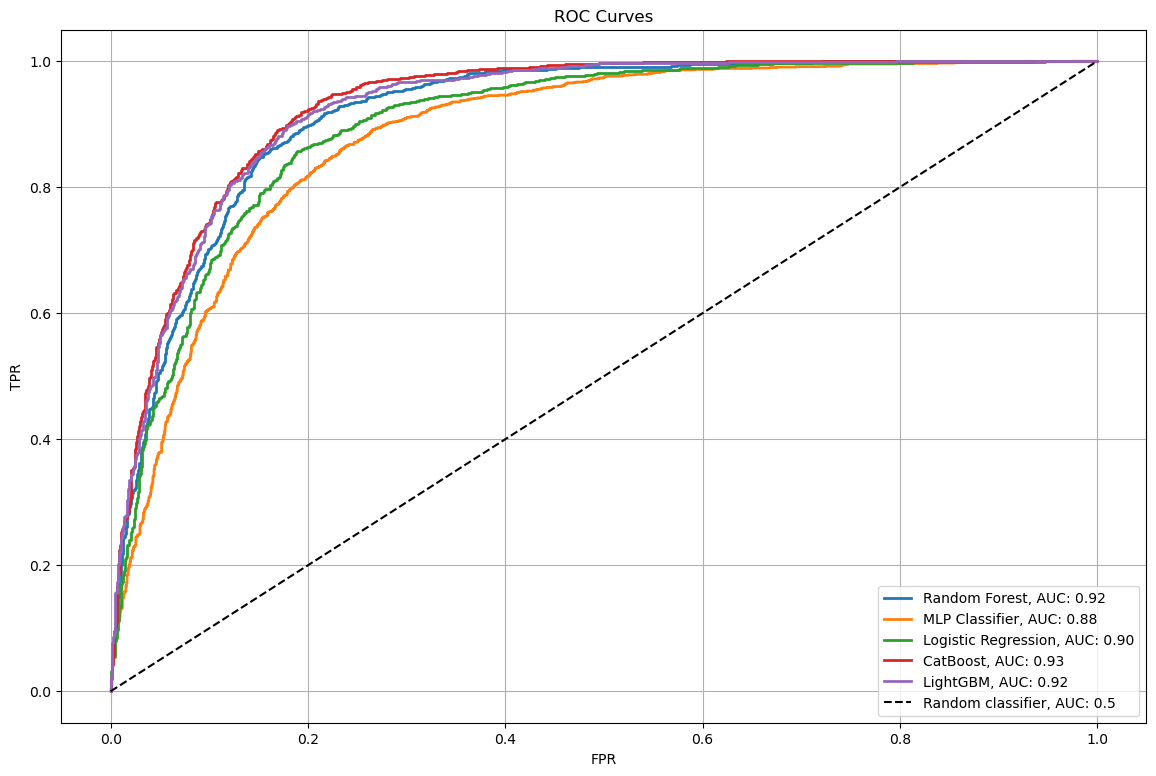

In [50]:
estimators = {
    'Random Forest': [best_forest, X_forest_test, y_forest_test],
    'MLP Classifier': [best_mlp, X_test, y_test],
    'Logistic Regression': [best_logreg, X_test, y_test],
    'CatBoost': [best_cat, X_cat_test, y_test],
    'LightGBM': [best_lgbm, X_cat_test, y_test]
}

plt.figure(figsize=(14, 9))
for i, estimator_name in enumerate(estimators):
    fpr, tpr, thresholds, auc = roc(estimators[estimator_name][0], estimators[estimator_name][1], estimators[estimator_name][2])

    plt.plot(
        fpr, tpr, 
        linewidth=2,
        label=f'{estimator_name}, AUC: {auc:.2f}'
    )

plt.plot([0, 1], [0, 1], 'k--', label='Random classifier, AUC: 0.5')

plt.title(f'ROC Curves')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend()

plt.show()